# Music Authorship

* Find this notebook at `EpyNN/nnlive/author_music/prepare_dataset.ipynb`. 
* Regular python code at `EpyNN/nnlive/author_music/prepare_dataset.py`.

This notebook is part of the series on preparing data for Neural Network regression with EpyNN. It deals with a real world problem and therefore will focus on the problem itself, rather than basics that were reviewed along with the preparation of dummy dataset [with Boolean](../dummy_boolean/prepare_dataset.ipynb), [with string](../dummy_string/prepare_dataset.ipynb), [with time-series (numerical)](../dummy_time/prepare_dataset.ipynb) and [with image (numerical)](../dummy_image/prepare_dataset.ipynb).

## Authorship prediction of artistic content



## Prepare ...

### Imports

In [1]:
# EpyNN/nnlive/author_music/prepare_dataset.ipynb
# Standard library imports
import tarfile
import random
import glob
import gzip
import wget
import os

# Related third party imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Local application/library specific imports
from nnlibs.commons.logs import process_logs

In [2]:
### Seeding

In [3]:
random.seed(1)

### Download music from author A and B

In [4]:
def download_music():
    """Download some guitar music.
    """
    data_path = os.path.join('.', 'data')

    if not os.path.exists(data_path):

        # Download @url with wget
        url = 'https://synthase.s3.us-west-2.amazonaws.com/author_music.tar'
        fname = wget.download(url)

        # Extract archive
        tar = tarfile.open(fname).extractall('.')
        process_logs('Make: '+fname, level=1)

        # Clean-up
        os.remove(fname)

    return None

Retrieve the data as follows.

In [5]:
download_music()

### Clip music

In [6]:
def clips_music(wav_file, TIME=1, SAMPLING_RATE=100):
    """Clip music and proceed with resampling.

    :param wav_file: The filename of .wav file which contains the music.
    :type wav_file: str

    :param SAMPLING_RATE: Sampling rate (Hz), default to 100.
    :type SAMPLING_RATE: int

    :param TIME: Sampling time (s), defaults to 1.
    :type TIME: int

    :return: Clipped and re-sampled music.
    :rtype: list[:class:`numpy.ndarray`]
    """
    # Number of features describing a sample
    N_FEATURES = int(SAMPLING_RATE * TIME)

    # Retrieve original sampling rate (Hz) and data
    wav_sampling_rate, wav_data = wavfile.read(wav_file)

    # 16-bits wav files - Pass all positive and norm. [0, 1]
    wav_data = (wav_data + np.abs(np.min(wav_data)))
    wav_data = wav_data / np.max(wav_data)

    # Digitize in 4-bits signal
    n_bins = 16
    bins = [i / (n_bins - 1) for i in range(n_bins)]
    wav_data = np.digitize(wav_data, bins, right=True)

    # Compute step for re-sampling
    sampling_step = int(wav_sampling_rate / SAMPLING_RATE)

    # Re-sampling to avoid memory allocation errors
    wav_resampled = wav_data[::sampling_step]

    # Total duration (s) of original data
    wav_time = wav_data.shape[0] / wav_sampling_rate

    # Number of clips to slice from original data
    N_CLIPS = int(wav_time / TIME)

    # Make clips from data
    clips = [wav_resampled[i * N_FEATURES:(i+1) * N_FEATURES] for i in range(N_CLIPS)]

    return clips


### Prepare dataset

In [7]:
def prepare_dataset(N_SAMPLES=100):
    """Prepare a dataset of clipped music as NumPy arrays.

    :param N_SAMPLES: Number of clip samples to retrieve, defaults to 100.
    :type N_SAMPLES: int

    :return: Set of sample features.
    :rtype: tuple[:class:`numpy.ndarray`]

    :return: Set of single-digit sample label.
    :rtype: tuple[:class:`numpy.ndarray`]
    """
    # Initialize X and Y datasets
    X_features = []
    Y_label = []

    wav_paths = os.path.join('data', '*', '*wav')

    wav_files = glob.glob(wav_paths)

    # Iterate over WAV_FILES
    for wav_file in wav_files:

        # Retrieve clips
        clips = clips_music(wav_file)

        # Iterate over clips
        for features in clips:

            # Clip is positive if played by true author (+) else negative (-)
            label = 1 if 'true' in wav_file else 0

            # Append sample features to X_features
            X_features.append(features)

            # Append sample label to Y_label
            Y_label.append(label)

    # Prepare X-Y pairwise dataset
    dataset = list(zip(X_features, Y_label))

    # Shuffle dataset
    random.shuffle(dataset)

    # Truncate dataset to N_SAMPLES
    dataset = dataset[:N_SAMPLES]

    # Separate X-Y pairs
    X_features, Y_label = zip(*dataset)

    return X_features, Y_label

Let's check the function.

(100,) 1


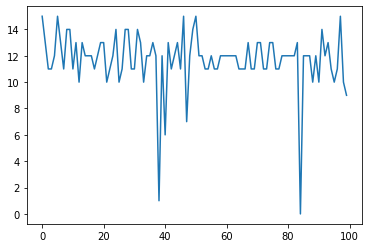

(100,) 1


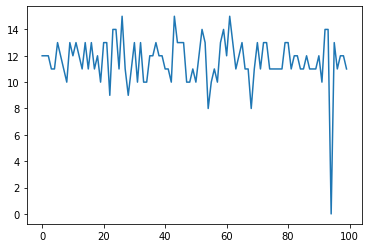

(100,) 0


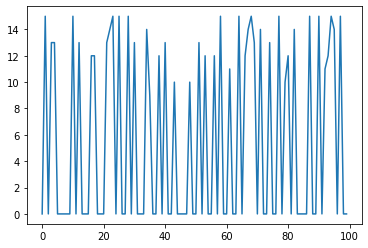

(100,) 0


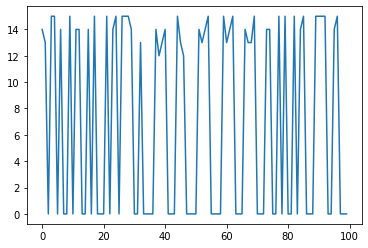

(100,) 0


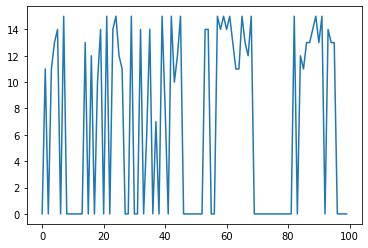

In [8]:
X_features, Y_label = prepare_dataset(N_SAMPLES=5)

for features, label in zip(X_features, Y_label):
    print(features.shape, label)
    
    plt.plot(features)
    plt.show()

_

## Live examples

The function ``prepare_dataset()`` presented herein is used in the following live examples:

* Notebook at`EpyNN/nnlive/author_music/train.ipynb` or following [this link](train.ypinb). 
* Regular python code at `EpyNN/nnlive/author_music/train.py`.